In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch画像用
import torchvision
import torchvision.transforms as transforms

# 画像表示用
import matplotlib.pyplot as plt

In [ ]:
batch_size = 128

# データセットの取得
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
# DataLoaderの作成
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

100%|██████████| 9912422/9912422 [00:00<00:00, 104280797.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88874316.82it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27024912.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22359775.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    self.fc = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_var = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x):
    # ニューラルネットワークで事後分布の平均・分散を計算する
    h = torch.relu(self.fc(x))
    mu = self.fc_mu(h) # μ
    log_var = self.fc_var(h) # log σ^2

    # 潜在変数を求める
    ## 標準正規乱数を振る
    eps = torch.randn_like(torch.exp(log_var))
    ## 潜在変数の計算 μ + σ・ε
    z = mu + torch.exp(log_var / 2) * eps
    return mu, log_var, z

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(latent_dim, hidden_dim)
    self.fc_output = nn.Linear(hidden_dim, input_dim)

  def forward(self, z):
      h = torch.relu(self.fc(z))
      output = torch.sigmoid(self.fc_output(h))
      return output

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(input_dim, hidden_dim, latent_dim)

  def forward(self, x):
    mu, log_var, z = self.encoder(x)
    x_decoded = self.decoder(z)
    return x_decoded, mu, log_var, z

In [ ]:
def loss_function(label, predict, mu, log_var):
  reconstruction_loss = F.binary_cross_entropy(predict, label, reduction='sum')
  kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  vae_loss = reconstruction_loss + kl_loss
  return vae_loss, reconstruction_loss, kl_loss

In [ ]:
image_size = 28 * 28
h_dim = 32
z_dim = 64
num_epochs = 1
learning_rate = 1e-3

model = VAE(image_size, h_dim, z_dim).to()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
losses = []
model.train()
for epoch in range(num_epochs):
  train_loss = 0
  for i, (x, labels) in enumerate(train_loader):
    # 予測
    x = x.to().view(-1, image_size).to(torch.float32)
    x_recon, mu, log_var, z = model(x)
    # 損失関数の計算
    loss, recon_loss, kl_loss = loss_function(x, x_recon, mu, log_var)

    # パラメータの更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 損失の表示
    if (i+1) % 10 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}, reconstruct loss: {recon_loss: 0.4f}, KL loss: {kl_loss: 0.4f}')
    losses.append(loss)

Epoch: 1, loss:  67620.3359, reconstruct loss:  67504.0078, KL loss:  116.3266
Epoch: 1, loss:  63946.9102, reconstruct loss:  63574.7695, KL loss:  372.1387
Epoch: 1, loss:  53965.1836, reconstruct loss:  51474.4023, KL loss:  2490.7812
Epoch: 1, loss:  42704.4883, reconstruct loss:  38492.8750, KL loss:  4211.6138
Epoch: 1, loss:  35252.0625, reconstruct loss:  32711.6504, KL loss:  2540.4119
Epoch: 1, loss:  32271.2129, reconstruct loss:  29709.7207, KL loss:  2561.4915
Epoch: 1, loss:  31190.5000, reconstruct loss:  29138.4141, KL loss:  2052.0854
Epoch: 1, loss:  30875.9805, reconstruct loss:  29131.0039, KL loss:  1744.9769
Epoch: 1, loss:  29611.3223, reconstruct loss:  27742.1348, KL loss:  1869.1880
Epoch: 1, loss:  29206.3594, reconstruct loss:  27654.5586, KL loss:  1551.8000
Epoch: 1, loss:  30087.9316, reconstruct loss:  28784.9395, KL loss:  1302.9927
Epoch: 1, loss:  28242.8535, reconstruct loss:  26876.3125, KL loss:  1366.5406
Epoch: 1, loss:  28721.5039, reconstruct l

In [ ]:
model.eval()

with torch.no_grad():
  z = torch.randn(25, z_dim).to()
  out = model.decoder(z)
out = out.view(-1, 28, 28)
out = out.cpu().detach().numpy()

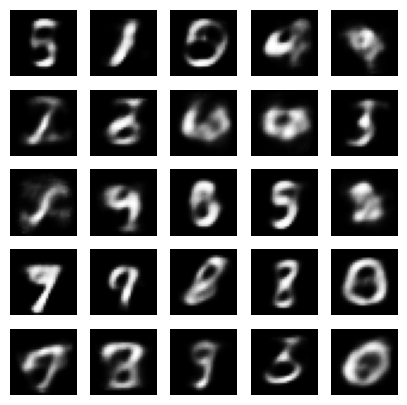

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
plt.gray()
for i in range(25):
  idx = divmod(i, 5)
  ax[idx].imshow(out[i])
  ax[idx].axis('off');
fig.show()